### 1. Import the required libraries.

In [1]:
# import libraries
import sys
sys.path.append("viewFormer")

from tqdm import tqdm, trange
import torch
import importlib
from timm import create_model
import matplotlib.pyplot as plt
from viewFormer.utils import get_model_layers, get_layer_weights, absmax
from viewFormer.visualize import outlier_heatmap

# check torch gpu availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

/home/scott/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


### 2. Load model and weights.

In [2]:
# load model
model_name = 'deit3_small_patch16_224'
model = create_model(model_name, pretrained=True)
model.eval()

# model_name = 'deit_small_patch16_224_cifar100'
# model = torch.load('/home/scott/coding/lab4/0.9099_deit3_small_patch16_224.pth', map_location='cpu')
# model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

### 3. Visualize the model's achitecture and its weights.

In [3]:
# find the layers you want to visualize

# get all layers
# get_model_layers(model) 

# define the layers you want to visualize here
def selected_layers(block_idx):
  return [f'blocks.{block_idx}.attn.qkv', f'blocks.{block_idx}.mlp.fc1', f'blocks.{block_idx}.mlp.fc2']

sample_block = get_model_layers(model, match_names=selected_layers(0), match_types=['Linear'])
print(sample_block)

[('blocks.0.attn.qkv', Linear(in_features=384, out_features=1152, bias=True)), ('blocks.0.mlp.fc1', Linear(in_features=384, out_features=1536, bias=True)), ('blocks.0.mlp.fc2', Linear(in_features=1536, out_features=384, bias=True))]


Block 0:   0%|          | 0/12 [00:00<?, ?it/s]

Block 7:  58%|█████▊    | 7/12 [00:12<00:08,  1.78s/it]


KeyboardInterrupt: 

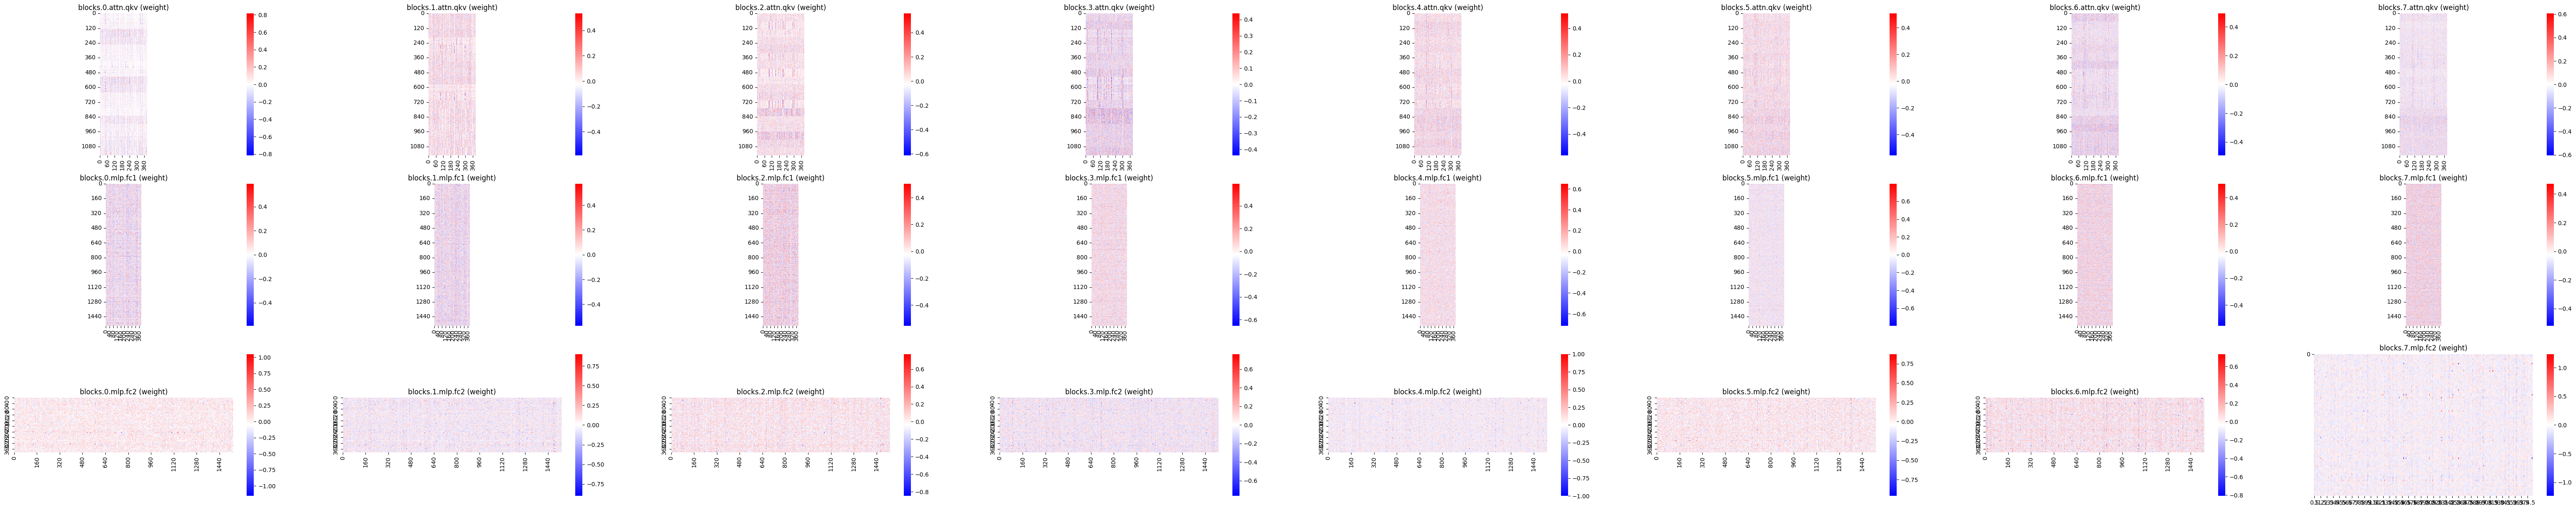

In [10]:
# get model's block_0 layers
sample_block = get_model_layers(model, match_names=selected_layers(0), match_types=['Linear'])

model_blocks_cnt = len(model.blocks)
block_layer_cnt = len(selected_layers(0))
layer_param_cnt = 1  # 2 for LRLinear

fig = plt.figure(figsize=(10*model_blocks_cnt, 5*block_layer_cnt*layer_param_cnt))
t = trange(model_blocks_cnt, desc='Blocks', leave=True)
for block_id in t:
    t.set_description(f'Block {block_id}')
    t.refresh()
    layers = get_model_layers(model, match_names=selected_layers(block_id), match_types=['Linear'])   
    for layer_id, (label, layer) in enumerate(layers):
        layer_weights = get_layer_weights(layer, match_names=['weight'])
        for weight_id, (name, weight) in enumerate(layer_weights):
            # print(f'{label} ({name})')
            ax = fig.add_subplot(block_layer_cnt*layer_param_cnt, model_blocks_cnt, layer_id*layer_param_cnt*model_blocks_cnt+block_id+1 + weight_id*model_blocks_cnt)
            ax.set_title(f'{label} ({name})')

            # convert to numpy
            weight = weight.cpu().detach().numpy()

            # reduce resolution for large weights to speed up plotting
            kernel_size = round(max(weight.shape)/360)

            # plot heatmap
            # abs_max = max(abs(weight.min()), abs(weight.max()))
            abs_max = absmax(weight)
            outlier_heatmap(weight, kernel_size=kernel_size, cmap='bwr', ax=ax, vmin=-abs_max, vmax=abs_max)
            plt.axis('scaled')

plt.tight_layout()
save_loc = f'{model_name}_weight.png'
plt.savefig(save_loc)

### Visualize the model's activations.

In [3]:
from torchvision import datasets, transforms
from timm.data import create_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.utils.data import DataLoader
import os

def build_dataset_CIFAR100(is_train, data_path):
    transform = build_transform(is_train)
    dataset = datasets.CIFAR100(data_path, train=is_train, transform=transform, download=True)
    nb_classes = 100
    return dataset, nb_classes

def build_transform(is_train):
    input_size = 224
    eval_crop_ratio = 1.0

    resize_im = input_size > 32
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=input_size,
            is_training=True,
            color_jitter=0.3,
            auto_augment='rand-m9-mstd0.5-inc1',
            interpolation='bicubic',
            re_prob=0.0,
            re_mode='pixel',
            re_count=1,
        )
        if not resize_im:
            # replace RandomResizedCropAndInterpolation with
            # RandomCrop
            transform.transforms[0] = transforms.RandomCrop(
                input_size, padding=4)
        return transform

    t = []
    if resize_im:
        size = int(input_size / eval_crop_ratio)
        t.append(
            transforms.Resize(size, interpolation=3),  # to maintain same ratio w.r.t. 224 images
        )
        t.append(transforms.CenterCrop(input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
    return transforms.Compose(t)

def prepare_data(batch_size):
    train_set, nb_classes = build_dataset_CIFAR100(is_train=True, data_path='./data')
    test_set, _ = build_dataset_CIFAR100(is_train=False, data_path='./data')

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader, test_loader, nb_classes

def evaluate_model(model, data_loader, device):
    # model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy}%')
    return accuracy

def train_one_epoch(model, criterion, optimizer, data_loader, device):

    cnt = 0

    for image, target in tqdm(data_loader):
        cnt += 1
        image, target = image.to(device), target.to(device)
        output = model(image)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [4]:
from viewFormer.hooks import HookHandler, get_act_func, get_avg_act_func, get_absmax_act_func
from viewFormer.data import calibrate

batch_size = 1
train_loader, test_loader, nb_classes = prepare_data(batch_size)

handler = HookHandler()
layer_outputs = {}

Files already downloaded and verified
Files already downloaded and verified


In [7]:
model_blocks_cnt = len(model.blocks)
block_layer_cnt = len(selected_layers(0))

for i in range(model_blocks_cnt):
    sample_block = get_model_layers(model, match_names=selected_layers(i), match_types=['Linear'])
    handler.create_hooks(sample_block, get_absmax_act_func, layer_outputs)

with torch.autocast(device_type="cuda"):
    calibrate(model, list(train_loader)[:256])
handler.remove_hooks()

Calibrate: [  0/256]	Time  0.488 ( 0.488)
Calibrate: [ 10/256]	Time  0.174 ( 0.214)
Calibrate: [ 20/256]	Time  0.170 ( 0.195)
Calibrate: [ 30/256]	Time  0.172 ( 0.189)
Calibrate: [ 40/256]	Time  0.175 ( 0.186)
Calibrate: [ 50/256]	Time  0.171 ( 0.183)
Calibrate: [ 60/256]	Time  0.168 ( 0.181)
Calibrate: [ 70/256]	Time  0.169 ( 0.180)
Calibrate: [ 80/256]	Time  0.169 ( 0.178)
Calibrate: [ 90/256]	Time  0.169 ( 0.177)
Calibrate: [100/256]	Time  0.182 ( 0.177)
Calibrate: [110/256]	Time  0.167 ( 0.176)
Calibrate: [120/256]	Time  0.168 ( 0.176)
Calibrate: [130/256]	Time  0.168 ( 0.175)
Calibrate: [140/256]	Time  0.170 ( 0.175)
Calibrate: [150/256]	Time  0.169 ( 0.174)
Calibrate: [160/256]	Time  0.170 ( 0.174)
Calibrate: [170/256]	Time  0.167 ( 0.173)
Calibrate: [180/256]	Time  0.169 ( 0.173)
Calibrate: [190/256]	Time  0.168 ( 0.173)
Calibrate: [200/256]	Time  0.176 ( 0.173)
Calibrate: [210/256]	Time  0.176 ( 0.173)
Calibrate: [220/256]	Time  0.176 ( 0.173)
Calibrate: [230/256]	Time  0.177 (

Block 11: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]


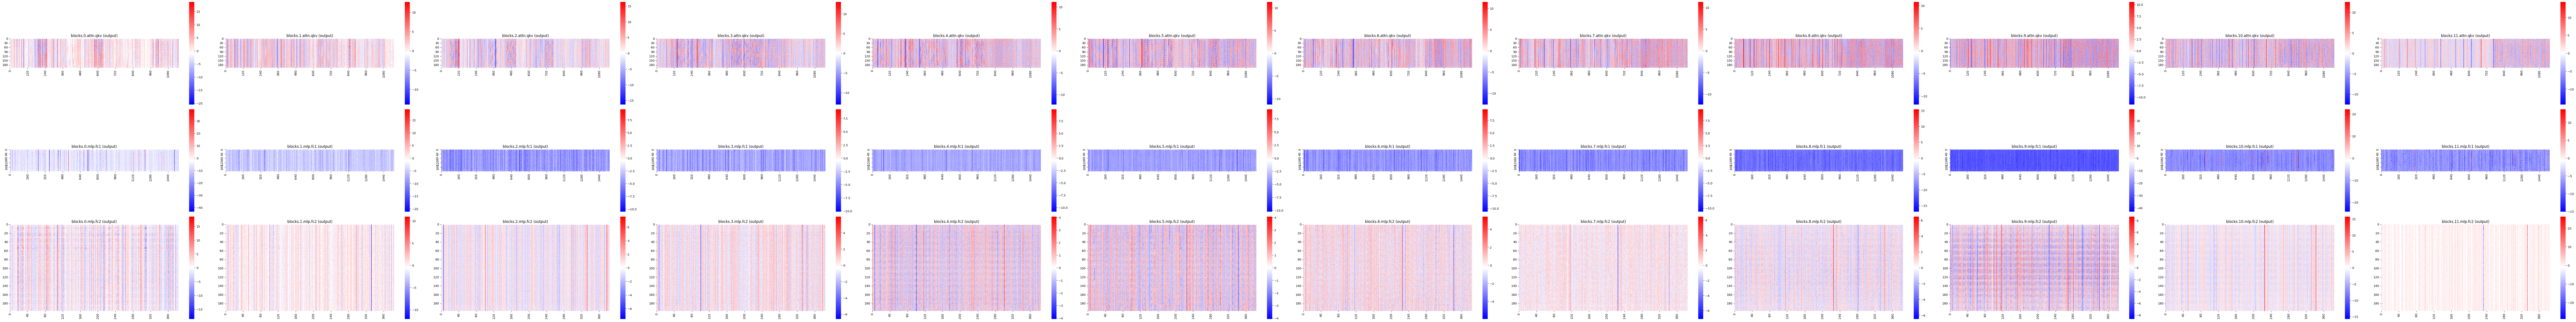

In [11]:
# get model's block_0 layers
sample_block = get_model_layers(model, match_names=selected_layers(0), match_types=['Linear'])

model_blocks_cnt = len(model.blocks)
block_layer_cnt = len(selected_layers(0))
layer_param_cnt = 1  # 2 for LRLinear

fig = plt.figure(figsize=(10*model_blocks_cnt, 5*block_layer_cnt*layer_param_cnt))
t = trange(model_blocks_cnt, desc='Blocks', leave=True)
for block_id in t:
    t.set_description(f'Block {block_id}')
    t.refresh()
    layers = get_model_layers(model, match_names=selected_layers(block_id), match_types=['Linear'])   
    for layer_id, (label, layer) in enumerate(layers):
        activation = layer_outputs[label]

        # print(f'{label} ({name})')
        ax = fig.add_subplot(block_layer_cnt*layer_param_cnt, model_blocks_cnt, layer_id*layer_param_cnt*model_blocks_cnt+block_id+1)
        ax.set_title(f'{label} (output)')

        # reduce resolution for large weights to speed up plotting
        kernel_size = round(max(activation.shape)/360)

        # plot heatmap
        abs_max = absmax(activation)
        outlier_heatmap(activation, kernel_size=kernel_size, cmap='bwr', ax=ax, vmin=-abs_max, vmax=abs_max)
        plt.axis('scaled')

plt.tight_layout()
save_loc = f'{model_name}_activation.png'
plt.savefig(save_loc)

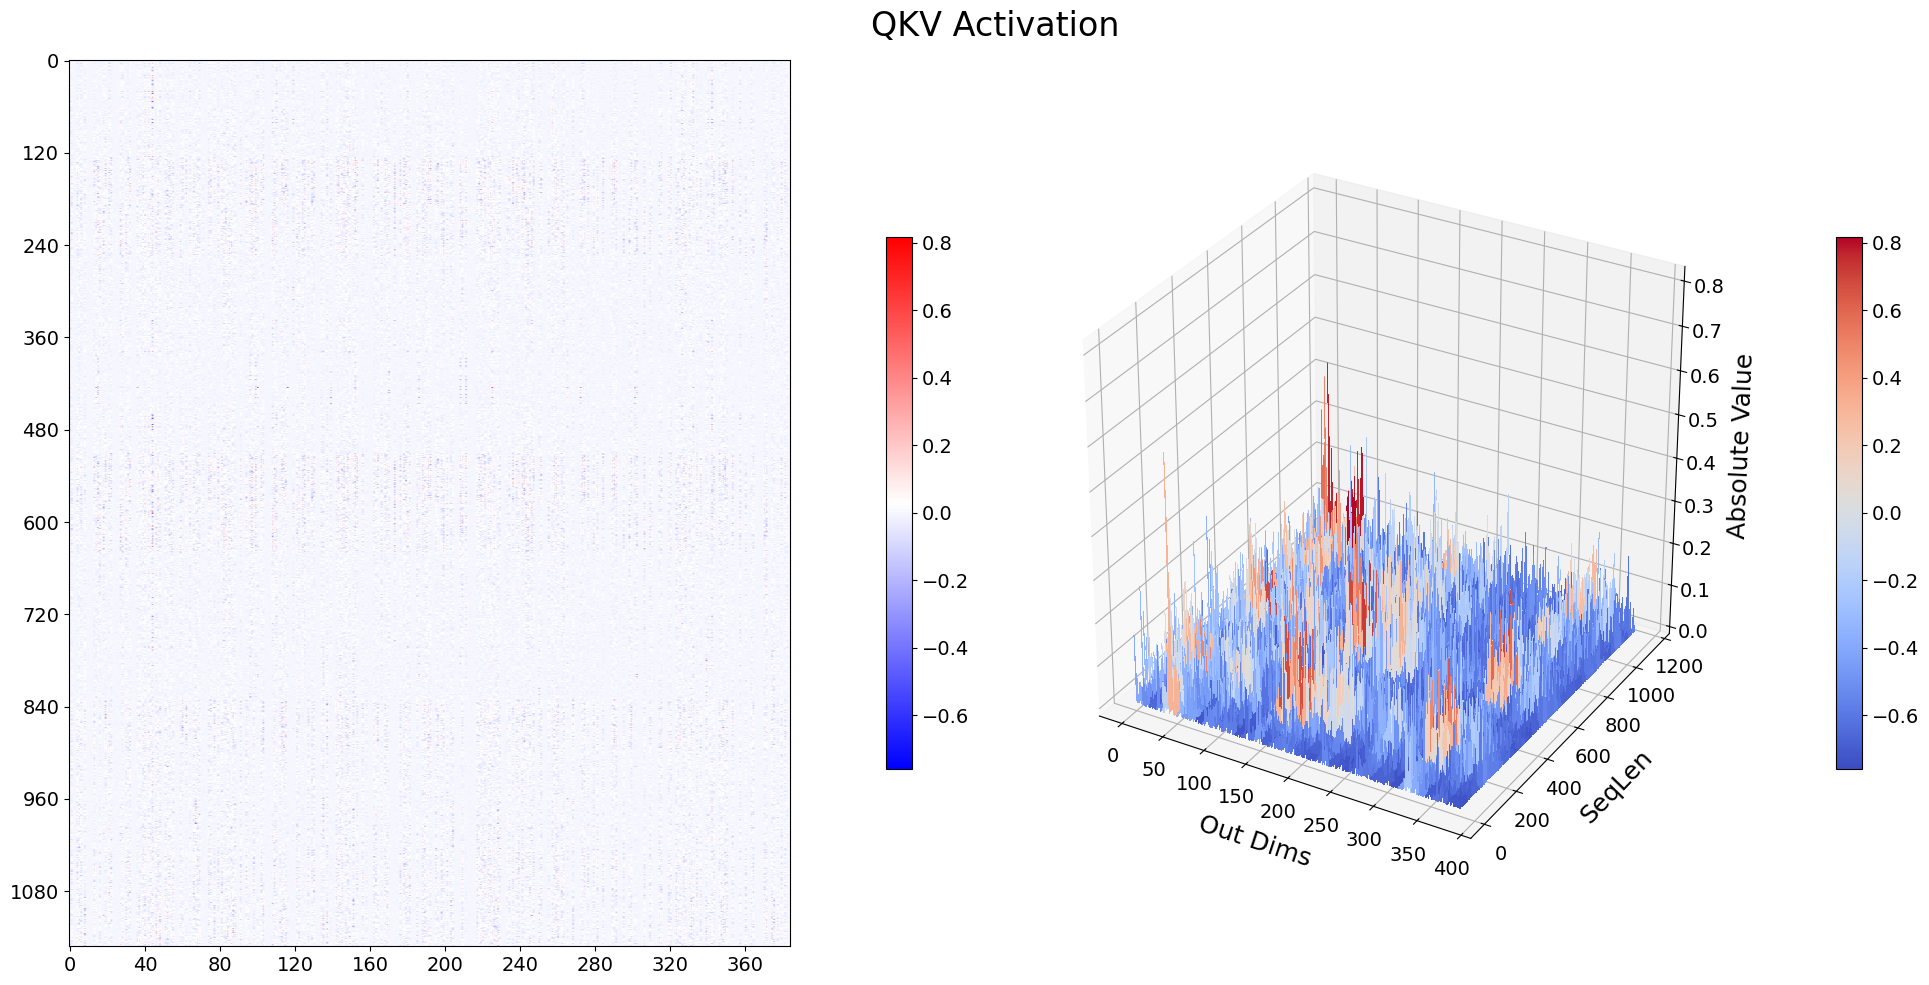

In [6]:
import numpy as np

import matplotlib as mpl
import matplotlib.style as mplstyle
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

from viewFormer.utils import absmax_reduce
from viewFormer.visualize import outlier_heatmap, abs_outlier_tensor

# layer_outputs
sample_block = get_model_layers(model, match_types=['Linear'])
# plot_tensor(sample_block[0][1].weight.cpu().detach().numpy(), title='QKV Weight')
# plot_tensor(layer_outputs['blocks.0.attn.qkv'], title='QKV Activation')

fig = plt.figure(figsize=(20, 10))
fig.suptitle('QKV Activation', fontsize=24)

ax = fig.add_subplot(1, 2, 1)
outlier_heatmap(sample_block[0][1].weight.cpu().detach().numpy(), kernel_size=1, cmap='bwr', ax=ax)

ax = fig.add_subplot(1, 2, 2, projection='3d')
abs_outlier_tensor(sample_block[0][1].weight.cpu().detach().numpy(), cmap='coolwarm', ax=ax)

plt.tight_layout()
plt.show()